Note: This notebook contains the operations performed after the data preparation. So here we have the cleaned dataset with the new feature just extracted. These are data on which we'll perform our initial explorative analysis.
Feature selection and scaling will be performed in the further predictive analysis phase.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/14 18:26:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/14 18:26:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df = spark.read.option('escape','"').csv('kickstarter_cleaned.csv', header=True, inferSchema=True, mode="DROPMALFORMED")

In [3]:
import pandas as pd
from pyspark.sql.functions import col, log, when, first, sum, count
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Null values

In [4]:
null_counts = [df.where(df[col].isNull()).count() for col in df.columns]
null_df = pd.DataFrame(list(zip(df.columns, null_counts)), columns=['Column', 'Number of Null Values'])
print("Number of Null Values for Each Column:")
print(null_df)

Number of Null Values for Each Column:
             Column  Number of Null Values
0              name                      0
1          category                      0
2     main_category                      0
3          currency                      0
4             state                      0
5           backers                      0
6           pledged                      1
7              goal                      1
8              year                      0
9             month                      0
10      day_of_week                      0
11    time_interval                      0
12  length_of_title                      0
13        use_of_?!                      0
14        continent                     47


# Number of unique values for categorical columns

In [5]:
categorical_columns = ['category', 'main_category', 'year', 'continent', 'currency', 'state', 'use_of_?!']

unique_counts = [df.select(col).distinct().count() for col in categorical_columns]
unique_df = pd.DataFrame(list(zip(categorical_columns, unique_counts)), columns=['Categorical Column', 'Number of Unique Values'])
print("\nNumber of Unique Values for Categorical Columns:")
print(unique_df)


Number of Unique Values for Categorical Columns:
  Categorical Column  Number of Unique Values
0           category                      159
1      main_category                       15
2               year                        9
3          continent                        5
4           currency                       14
5              state                        2
6          use_of_?!                        2


In [6]:
categorical_columns = ['main_category', 'year', 'continent', 'currency', 'state', 'use_of_?!']

# Display the frequency of each unique value in each categorical column
for column in categorical_columns:
    print(f"Frequency of each value in {column}:")
    df.groupBy(column).count().orderBy(col("count").desc()).show()

Frequency of each value in main_category:
+-------------+-----+
|main_category|count|
+-------------+-----+
| Film & Video|12229|
|        Music| 9884|
|   Publishing| 7656|
|        Games| 6321|
|   Technology| 5856|
|       Design| 5506|
|          Art| 5473|
|         Food| 4801|
|      Fashion| 4281|
|      Theater| 2199|
|       Comics| 2185|
|  Photography| 2039|
|       Crafts| 1693|
|   Journalism|  894|
|        Dance|  780|
+-------------+-----+

Frequency of each value in year:


+----+-----+
|year|count|
+----+-----+
|2015|14120|
|2014|12931|
|2016|10653|
|2017| 9390|
|2013| 8897|
|2012| 8225|
|2011| 5295|
|2010| 2027|
|2009|  259|
+----+-----+

Frequency of each value in continent:
+---------+-----+
|continent|count|
+---------+-----+
|  America|59560|
|   Europe|10308|
|  Oceania| 1668|
|     Asia|  214|
|     NULL|   47|
+---------+-----+

Frequency of each value in currency:
+--------+-----+
|currency|count|
+--------+-----+
|     USD|56623|
|     GBP| 6368|
|     EUR| 3155|
|     CAD| 2669|
|     AUD| 1408|
|     SEK|  332|
|     MXN|  303|
|     NZD|  260|
|     DKK|  188|
|     NOK|  141|
|     CHF|  136|
|     SGD|  106|
|     HKD|  105|
|     JPY|    3|
+--------+-----+

Frequency of each value in state:
+----------+-----+
|     state|count|
+----------+-----+
|    failed|42618|
|successful|29179|
+----------+-----+

Frequency of each value in use_of_?!:


+---------+-----+
|use_of_?!|count|
+---------+-----+
|        0|64477|
|        1| 7320|
+---------+-----+



# Statistics of numerical columns

In [7]:
df_fail = df.filter(col('state')=='failed')
df_success = df.filter(col('state')=='successful')

In [8]:
columns = ["goal", "pledged", "backers"]

df_summary = df_fail.select(columns).describe()
print("Statistics of numerical column for failed project")
df_summary.show()

Statistics of numerical column for failed project
+-------+------------------+------------------+-----------------+
|summary|              goal|           pledged|          backers|
+-------+------------------+------------------+-----------------+
|  count|             42617|             42617|            42618|
|   mean|64463.273239552385|1304.3280803435246|16.08132713876766|
| stddev| 1614422.203665563|  6798.62993433892|67.00640823559797|
|    min|               1.0|               0.0|                0|
|    max|    1.6636139071E8|         757352.94|             5338|
+-------+------------------+------------------+-----------------+



In [9]:
columns = ["goal", "pledged", "backers"]

df_summary = df_success.select(columns).describe()
print("Statistics of numerical column for successful project")
df_summary.show()

Statistics of numerical column for successful project
+-------+-----------------+------------------+------------------+
|summary|             goal|           pledged|           backers|
+-------+-----------------+------------------+------------------+
|  count|            29179|             29179|             29179|
|   mean|9471.140063059034|22738.753225264838|263.33109428013296|
| stddev|24572.38821041222|135100.11855901973|1532.0746481185479|
|    min|             0.49|               1.0|                 0|
|    max|        1000000.0|        8596474.58|            154926|
+-------+-----------------+------------------+------------------+



# Data Exploration

### Analazying projects by goal and number of backers

It is necessary to pass to the log(goal) to plot the goal column. There's many values equal to zero or near to zero that make the plot and, in particular the relationship of goal of successful project vs goal of failed project, difficult to analyze. The same reasoning for backers.

In [10]:
df_goal = df.select("goal", "state")

df_goal_log = df_goal.withColumn("goal_log", log(col("goal") + 1))

In [11]:
pandas_df_goal = df_goal_log.select("goal_log", "state").sample(fraction=0.1).toPandas()

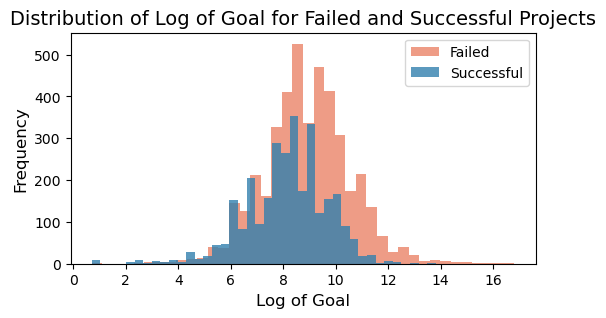

In [12]:
plt.figure(figsize=(6, 3))
plt.hist(pandas_df_goal[pandas_df_goal["state"] == "failed"]["goal_log"], bins=40, alpha=0.6, label="Failed", color="#e45a35")
plt.hist(pandas_df_goal[pandas_df_goal["state"] == "successful"]["goal_log"], bins=40, alpha=0.8, label="Successful", color="#3280ae")
plt.title("Distribution of Log of Goal for Failed and Successful Projects", fontsize=14)
plt.xlabel("Log of Goal", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# the 2 distributions essentially overlaps but
# low-medium value of goal seems better result in a successful project than medium-high values

In [13]:
df_backers = df.select("backers", "state")
df_backers_log = df_backers.withColumn("log_backers", log(col("backers") + 1))

In [14]:
pandas_df_backers = df_backers_log.select("log_backers", "state").sample(fraction=0.1).toPandas()

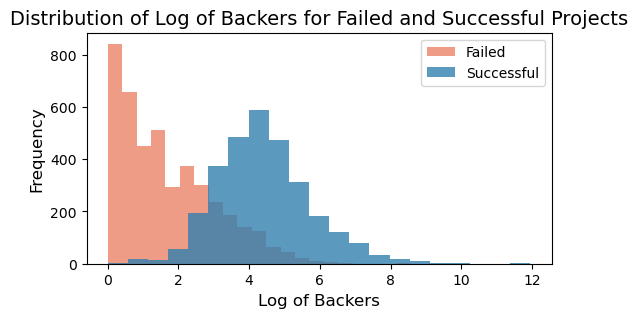

In [15]:
plt.figure(figsize=(6, 3))
plt.hist(pandas_df_backers[pandas_df_backers["state"] == "failed"]["log_backers"], bins=21, alpha=0.6, label="Failed", color="#e45a35")
plt.hist(pandas_df_backers[pandas_df_backers["state"] == "successful"]["log_backers"], bins=21, alpha=0.8, label="Successful", color="#3280ae")
plt.title("Distribution of Log of Backers for Failed and Successful Projects", fontsize=14)
plt.xlabel("Log of Backers", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# high number of backers is more prone to produce a success

In [16]:
df_sub = df.select("goal", "backers", "state")
df_sub_log = df_sub.withColumn("log_backers", log(col("backers") + 1))
df_sub_log = df_sub_log.withColumn("log_goal", log(col("goal") + 1))

pandas_df_sub = df_sub_log.select("log_backers", "log_goal", "state").sample(fraction=0.1).toPandas()

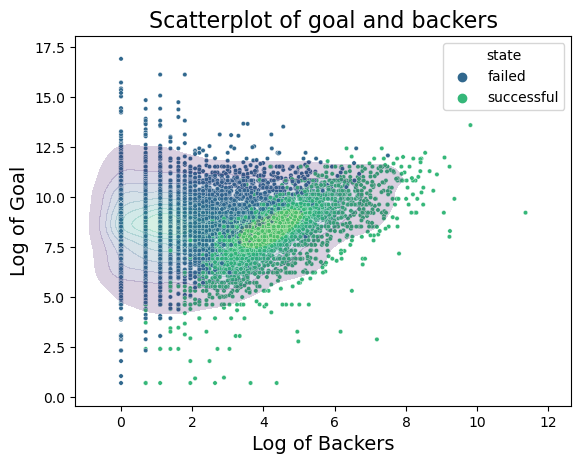

In [17]:
# scatterplot overlapped on kernel density plot: we visualize points of the two variables
# and the probability distribution around each point.

sns.scatterplot(x='log_backers', y='log_goal', hue='state', data=pandas_df_sub, palette='viridis', s=10, alpha=1)
sns.kdeplot(x='log_backers', y='log_goal', data=pandas_df_sub, cmap='viridis', fill=True, alpha=0.2)
plt.xlabel('Log of Backers', fontsize=14)
plt.ylabel('Log of Goal', fontsize=14)
plt.title('Scatterplot of goal and backers', fontsize=16)
plt.show()

### Analazying projects by category and time

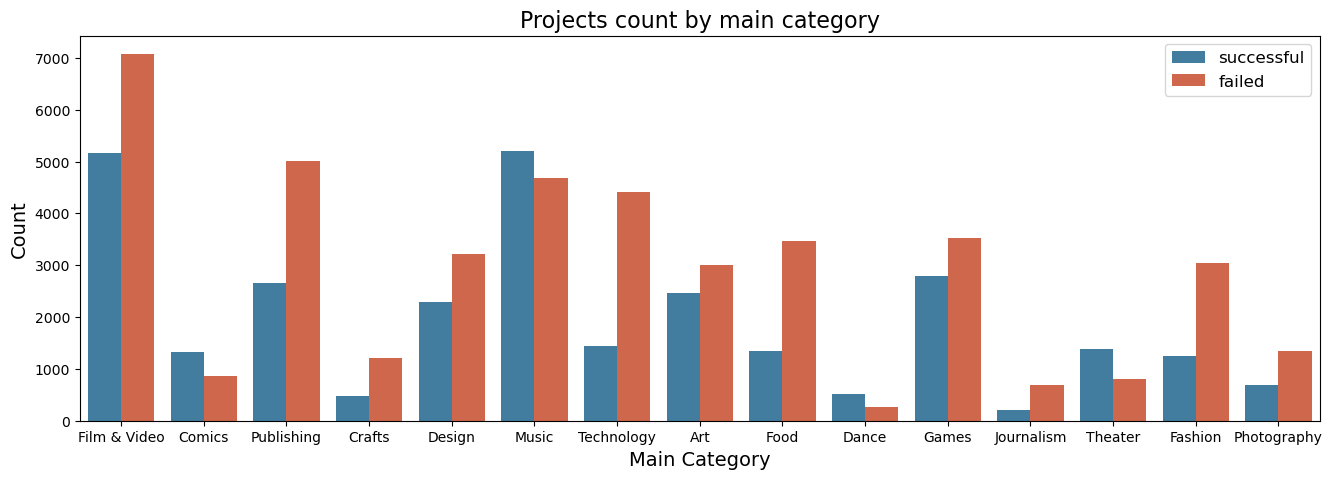

In [18]:
agg_df = df.groupBy("main_category", "state").count()
pandas_df = agg_df.toPandas()

fig, ax = plt.subplots(figsize=(16, 5))

ax = sns.barplot(x="main_category", y="count", hue="state", data=pandas_df, palette=["#3280ae", "#e45a35"])
ax.set_title("Projects count by main category", fontsize=16)
ax.set_xlabel("Main Category", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend(loc='upper right', fontsize=12)

plt.show()

In [ ]:
# How, inside categories, successful and failed projects are distributed.
# See below values of ratio and support of successful/failed projects

#### Top 5 best categories

In [19]:
#pivot -> rotate the table
#agg -> aggregate the count: count columns summed for each combination of "main_category" and "state"
pivoted_df = agg_df.groupBy("main_category").pivot("state").agg({"count": "sum"})

# Calculate the ratio column
result_df = pivoted_df.withColumn(
    "success_failure_ratio", (col("successful") / col("failed"))
)
sorted_df = result_df.orderBy(col("success_failure_ratio").desc())

top_5_categories = sorted_df.select("main_category", "success_failure_ratio", "successful", "failed").limit(5).show()

+-------------+---------------------+----------+------+
|main_category|success_failure_ratio|successful|failed|
+-------------+---------------------+----------+------+
|        Dance|   1.9885057471264367|       519|   261|
|      Theater|   1.7215346534653466|      1391|   808|
|       Comics|    1.523094688221709|      1319|   866|
|        Music|    1.111965811965812|      5204|  4680|
|          Art|   0.8231179213857428|      2471|  3002|
+-------------+---------------------+----------+------+



#### Top 5 worst categories

In [20]:
sorted_df = result_df.orderBy(col("success_failure_ratio"))

top_5_categories = sorted_df.select("main_category", "success_failure_ratio", "successful", "failed").limit(5).show()

+-------------+---------------------+----------+------+
|main_category|success_failure_ratio|successful|failed|
+-------------+---------------------+----------+------+
|   Journalism|  0.30701754385964913|       210|   684|
|   Technology|   0.3248868778280543|      1436|  4420|
|         Food|   0.3863701992492059|      1338|  3463|
|       Crafts|  0.39226973684210525|       477|  1216|
|      Fashion|   0.4096147513994073|      1244|  3037|
+-------------+---------------------+----------+------+



#### How categories evolve over time

In [21]:
#df_filtered = df.filter((col("main_category")=="Film & Video") | (col("main_category")=="Music") | (col("main_category")=="Publishing")
                                #| (col("main_category")=="Technology") )
df_filtered = df
df_filtered = df_filtered.filter(col("year").between(2010, 2017))
df_sub = df_filtered.select("state", "main_category", "year")

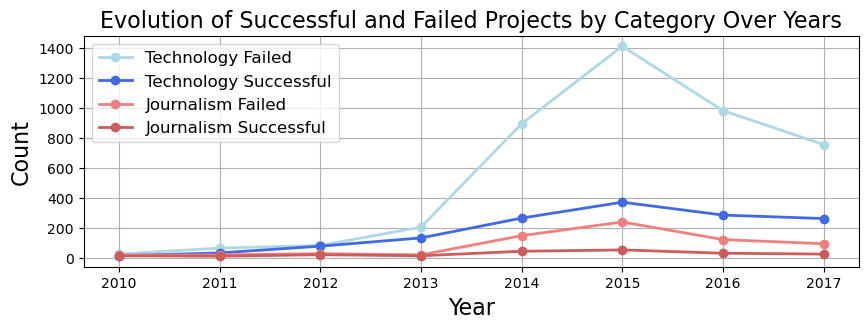

In [22]:
# Group data by main_category, state, and year
grouped_df = df_sub.groupBy("main_category", "state", "year").count()

# Pivot the DataFrame to have separate columns for successful and failed counts
pivoted_df = grouped_df.groupBy("main_category", "year").pivot("state").agg({"count": "sum"})

# Fill missing values with 0
pivoted_df = pivoted_df.na.fill(0)

# Convert to Pandas for plotting
pandas_df = pivoted_df.toPandas()
pandas_df = pandas_df.sort_values(by="year")

# Plot the line plot
plt.figure(figsize=(10, 3))
#e45a35
#3280ae
color_dict = {
    "Technology": {"successful": "royalblue", "failed": "lightblue"},
    "Journalism": {"successful": "indianred", "failed": "lightcoral"},
    "Theater": {"successful": "hotpink", "failed": "pink"},
    "Dance": {"successful": "green", "failed": "lightgreen"}
}

for category in ["Technology", "Journalism"]:
    category_df = pandas_df[pandas_df["main_category"] == category]
    plt.plot(category_df["year"], category_df["failed"], label=f"{category} Failed", marker='o', linestyle='-', linewidth=2, color=color_dict[category]["failed"])
    plt.plot(category_df["year"], category_df["successful"], label=f"{category} Successful", marker='o', linestyle='-', linewidth=2, color=color_dict[category]["successful"])

plt.title("Evolution of Successful and Failed Projects by Category Over Years", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(True)
plt.show()

In [ ]:
# We notice a peak of failed technology projects in 2014-2016
# 2015 is the year with an increase of number of total project, so, as consequence also failed and successful ones increase

### Influence of length of the title

In [24]:
df_title = df.select("length_of_title", "state")
pandas_df_title = df_title.select("length_of_title", "state").sample(fraction=0.5).toPandas()

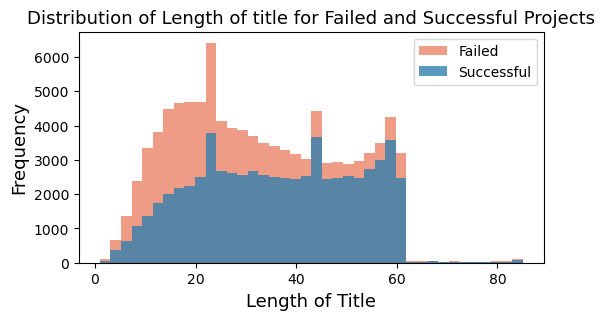

In [25]:
plt.figure(figsize=(6, 3))
plt.hist(pandas_df_title[pandas_df_title["state"] == "failed"]["length_of_title"], bins=40, alpha=0.6, label="Failed", color="#e45a35")
plt.hist(pandas_df_title[pandas_df_title["state"] == "successful"]["length_of_title"], bins=40, alpha=0.8, label="Successful", color="#3280ae")
plt.title("Distribution of Length of title for Failed and Successful Projects", fontsize=13)
plt.xlabel("Length of Title", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# The distributions are pretty similar, but shorter titles are a bit more associated with failed projects.

### Analyzing projects by date features (year, month, day_of_the_week and time_interval)

In [26]:
result = df.groupBy("state").agg({"time_interval": "mean"}).show()

+----------+------------------+
|     state|avg(time_interval)|
+----------+------------------+
|    failed| 35.17332173438061|
|successful|32.156446893009644|
+----------+------------------+



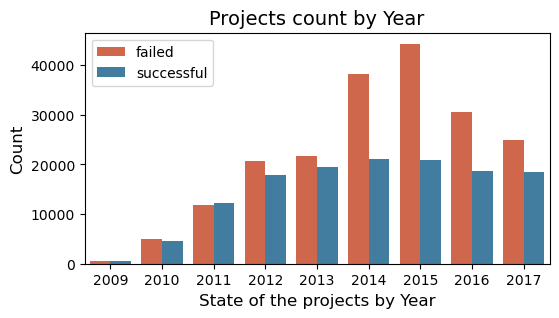

In [27]:
agg_df = df.groupBy("year", "state").count()
pandas_df = agg_df.toPandas()

fig, ax = plt.subplots(figsize=(6, 3))

ax = sns.barplot(x="year", y="count", hue="state", data=pandas_df, palette=["#e45a35", "#3280ae"])
ax.set_title("Projects count by Year", fontsize=14)
ax.set_xlabel("State of the projects by Year", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.legend(loc='upper left')

plt.show()

In [ ]:
# successful projects haven't the same peaked distribution as failed one, and seems to be less sensitive to 
# the increase of total number of projects around 2015

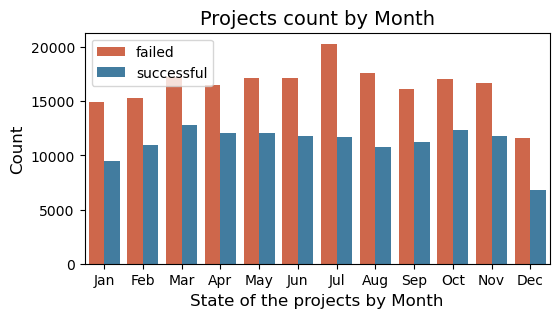

In [28]:
import calendar

agg_df = df.groupBy("month", "state").count()
pandas_df = agg_df.toPandas()

fig, ax = plt.subplots(figsize=(6, 3))

ax = sns.barplot(x="month", y="count", hue="state", data=pandas_df, palette=["#e45a35", "#3280ae"])

ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
ax.set_title("Projects count by Month", fontsize=14)
ax.set_xlabel("State of the projects by Month", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.legend(loc='upper left')

plt.show()

In [ ]:
# in July and August (summer) we notice that failed/successful projects rate is more imbalanced than in other periods

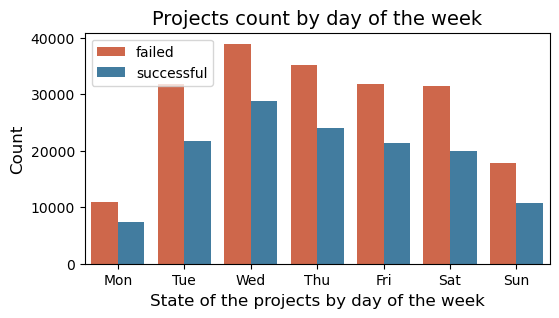

In [29]:
agg_df = df.groupBy("day_of_week", "state").count()
pandas_df = agg_df.toPandas()

fig, ax = plt.subplots(figsize=(6, 3))

ax = sns.barplot(x="day_of_week", y="count", hue="state", data=pandas_df, palette=["#e45a35", "#3280ae"])

day_abbr = [calendar.day_abbr[i] for i in range(7)]
ax.set_xticklabels(day_abbr)
ax.set_title("Projects count by day of the week", fontsize=14)
ax.set_xlabel("State of the projects by day of the week", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.legend(loc='upper left')

plt.show()

In [ ]:
# The variation regards only the number of published projects, not the final outcome

In [46]:
df_time = df.select("time_interval", "state")
pandas_df_time = df_time.select("time_interval", "state").sample(fraction=0.5).toPandas()

/tmp/ipykernel_596/2264621760.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(pandas_df_time[pandas_df_title["state"] == "failed"]["time_interval"], bins=12, alpha=0.6, label="Failed", color="#e45a35")
/tmp/ipykernel_596/2264621760.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(pandas_df_time[pandas_df_title["state"] == "successful"]["time_interval"], bins=12, alpha=0.8, label="Successful", color="#3280ae")


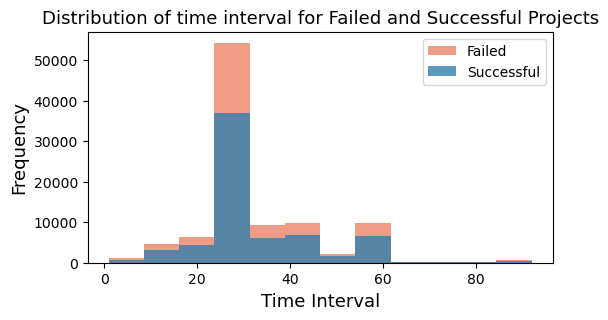

In [48]:
plt.figure(figsize=(6, 3))
plt.hist(pandas_df_time[pandas_df_title["state"] == "failed"]["time_interval"], bins=12, alpha=0.6, label="Failed", color="#e45a35")
plt.hist(pandas_df_time[pandas_df_title["state"] == "successful"]["time_interval"], bins=12, alpha=0.8, label="Successful", color="#3280ae")
plt.title("Distribution of time interval for Failed and Successful Projects", fontsize=13)
plt.xlabel("Time Interval", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# very similar average duration of successful and failed projects: 32 (success) and 35 (failure) days...

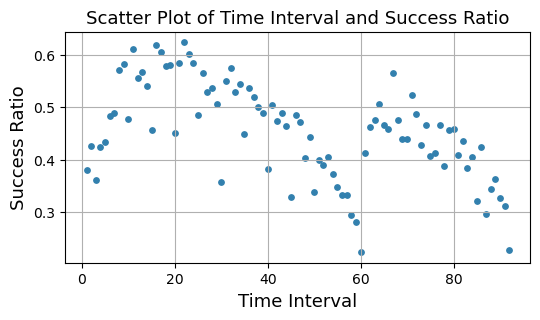

In [63]:
df_time = df.groupBy("time_interval").agg((sum((df["state"] == "successful").cast("int")) / count("*")).alias("success_ratio"))

pandas_df_time = df_time.toPandas()

plt.figure(figsize=(6, 3))
plt.scatter(pandas_df_time["time_interval"], pandas_df_time["success_ratio"], color="#3280ae", s=15)
plt.title("Scatter Plot of Time Interval and Success Ratio", fontsize=13)
plt.xlabel("Time Interval", fontsize=13)
plt.ylabel("Success Ratio", fontsize=13)
plt.grid(True)
plt.show()

In [ ]:
# ... but a shorter campaign seems to result slightly more in a successful project

#### Analyzing title feature

In [32]:
df.groupBy("use_of_?!").count().orderBy("count", ascending=False).show()

+---------+------+
|use_of_?!| count|
+---------+------+
|        0|298237|
|        1| 33438|
+---------+------+



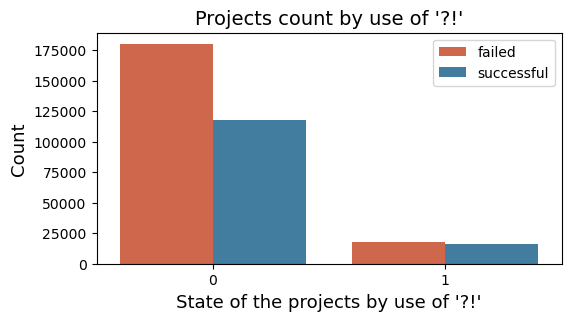

In [33]:
agg_df = df.groupBy("use_of_?!", "state").count()
pandas_df = agg_df.toPandas()

fig, ax = plt.subplots(figsize=(6, 3))

ax = sns.barplot(x="use_of_?!", y="count", hue="state", data=pandas_df, palette=["#e45a35", "#3280ae"])

ax.set_title("Projects count by use of '?!'", fontsize=14)
ax.set_xlabel("State of the projects by use of '?!'", fontsize=13)
ax.set_ylabel("Count", fontsize=13)
ax.legend(loc='upper right')

plt.show()

In [ ]:
# Few projects have those symbols in title: seems that the presence of them let the 2 outcomes be more balanced.

### Success rate by continent

In [35]:
df_continent = df.select("continent", "state")
df_continent = df_continent.dropna()

continent_state_counts = df_continent.groupBy('continent', 'state').count().groupBy('continent').pivot('state').agg(first('count'))
continent_state_counts = continent_state_counts.withColumn('success_rate', col('successful') / (col('successful') + col('failed')))

continent_state_pandas = continent_state_counts.toPandas()

In [36]:
continent_state_pandas

,continent,failed,successful,success_rate
0,Europe,30317,17163,0.361479
1,Oceania,5432,2458,0.311534
2,Asia,553,401,0.420335
3,America,161312,113829,0.413712
